### Imports & Options

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import osmnx as ox
import matplotlib.pyplot as plt

In [3]:
from src.directories import DATA_DIR
from src import rides, graph, utils

### Data

In [4]:
# chicago = graph.download_biking_network()
df = rides.load_data()

In [5]:
df.head()

,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual,same_start_and_end,duration,seconds,distance
0,9340B064F0AEE130,electric_bike,2023-07-23 20:06:14,2023-07-23 20:22:44,Kedzie Ave & 110th St,20204,Public Rack - Racine Ave & 109th Pl,877,41.692406,-87.700905,41.694835,-87.653041,member,False,0 days 00:16:30,990,2.475151
1,D1460EE3CE0D8AF8,classic_bike,2023-07-23 17:05:07,2023-07-23 17:18:37,Western Ave & Walton St,KA1504000103,Milwaukee Ave & Grand Ave,13033,41.898418,-87.686596,41.891578,-87.648384,member,False,0 days 00:13:30,810,2.021301
2,DF41BE31B895A25E,classic_bike,2023-07-23 10:14:53,2023-07-23 10:24:29,Western Ave & Walton St,KA1504000103,Damen Ave & Pierce Ave,TA1305000041,41.898418,-87.686596,41.909396,-87.677692,member,False,0 days 00:09:36,576,0.886014
3,9624A293749EF703,electric_bike,2023-07-21 08:27:44,2023-07-21 08:32:40,Racine Ave & Randolph St,13155,Clinton St & Madison St,TA1305000032,41.884112,-87.656943,41.882752,-87.641190,member,False,0 days 00:04:56,296,0.815781
4,2F68A6A4CDB4C99A,classic_bike,2023-07-08 15:46:42,2023-07-08 15:58:08,Clark St & Leland Ave,TA1309000014,Montrose Harbor,TA1308000012,41.967088,-87.667291,41.963982,-87.638181,member,False,0 days 00:11:26,686,1.510812


### Bicycle Trips

In [6]:
# ox.plot_graph(chicago, node_size=0)

#### Quick Summary of Rides Table

In [7]:
first = df["started_at"].min().strftime("%A, %B %-d")
last = df["ended_at"].max().strftime("%A, %B %-d")
f"{df.shape[0]:,} trips between {first}, and {last}."

'721,714 trips between Saturday, July 1, and Tuesday, August 1.'

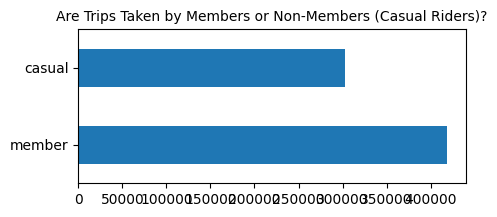

In [8]:
fig, ax = plt.subplots(figsize=(5,2))
df["member_casual"].value_counts().plot.barh(ax=ax)
ax.set_title("Are Trips Taken by Members or Non-Members (Casual Riders)?", fontsize=10)
ax.set_ylabel("");

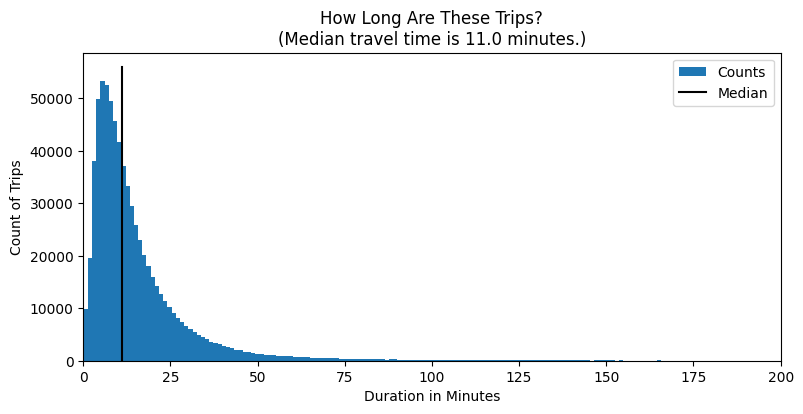

In [9]:
fig, ax = plt.subplots(figsize=(9,4))
ax = df["duration"].apply(lambda td: td.seconds / 60).plot.hist(ax=ax, bins=400, label="Counts")

_median = df["duration"].apply(lambda td: td.seconds / 60).median()
_median = round(_median, 1)
ax.plot([_median, _median], [0, ax.get_ylim()[1]], color="k", label="Median")

ax.set_title(f"How Long Are These Trips?\n(Median travel time is {_median} minutes.)")
ax.set_ylabel("Count of Trips")
ax.set_xlabel("Duration in Minutes")
ax.set_xlim([0,200])
ax.legend()

In [10]:
crow_flies = lambda row: utils.as_the_crow_flies_distance(row.start_lat, row.start_lng, row.end_lat, row.end_lng)
df["distance"] = df.apply(crow_flies, axis=1)

Text(0, 0.5, 'Count of Trips')

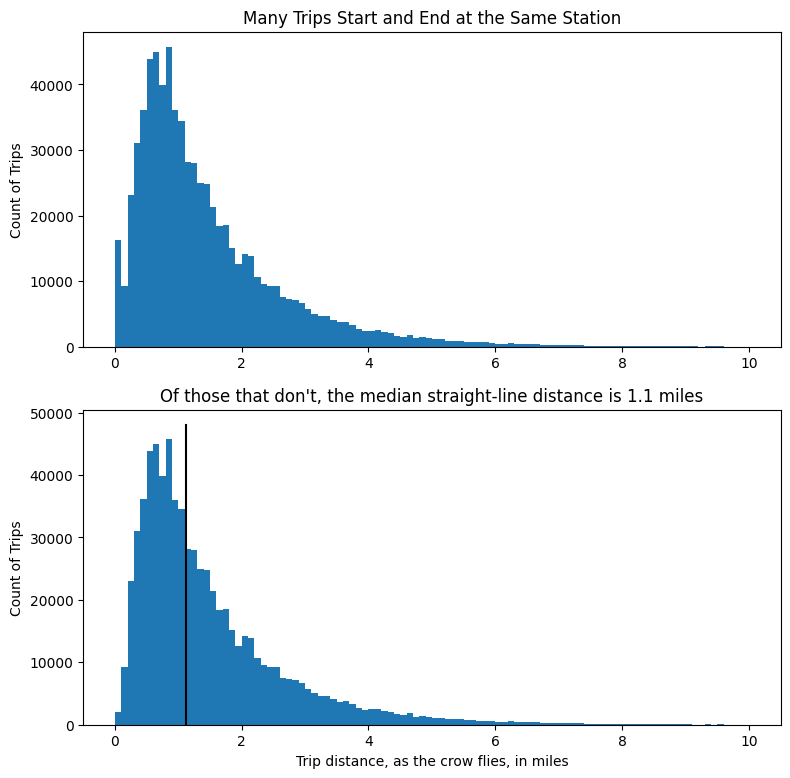

In [11]:
fig, ax = plt.subplots(nrows=2, figsize=(9,9))

chart_df = df[df["distance"] <= 10]

bin_width = 0.1
data = chart_df["distance"].values
bins = np.arange(min(data), max(data) + bin_width, bin_width)
chart_df["distance"].plot.hist(ax=ax[0], bins=bins)
ax[0].set_title("Many Trips Start and End at the Same Station")
ax[0].set_ylabel("Count of Trips")

chart_df = chart_df[chart_df["distance"] > 0]
chart_df["distance"].plot.hist(ax=ax[1], bins=bins)
_median = df[df["distance"] > 0]["distance"].median()
ax[1].plot([_median, _median], [0, ax[1].get_ylim()[1]], color="k")
_median = round(_median, 1)
ax[1].set_title(f"Of those that don't, the median straight-line distance is {_median} miles")
ax[1].set_xlabel("Trip distance, as the crow flies, in miles")
ax[1].set_ylabel("Count of Trips")

##### How long are the trips that start and end at the same location?

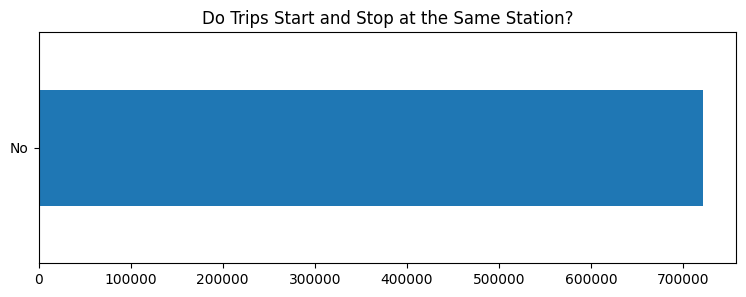

In [12]:
fig, ax = plt.subplots(figsize=(9,3))
df["same_start_and_end"].apply(lambda bl: "Yes" if bl else "No").value_counts().plot.barh(ax=ax)
ax.set_title("Do Trips Start and Stop at the Same Station?")
ax.set_ylabel("");

<Axes: ylabel='Frequency'>

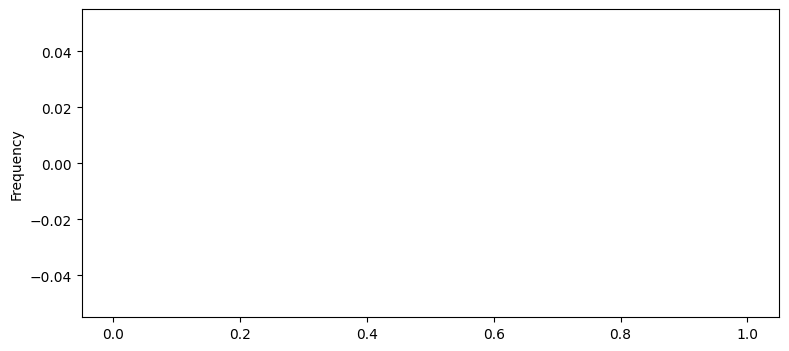

In [13]:
fig, ax = plt.subplots(figsize=(9,4))
round_trips = df[df["same_start_and_end"]]
round_trips["duration_seconds"] = round_trips["duration"].apply(lambda td: td.days*24*60*60 + td.seconds)
round_trips["duration_seconds"].plot.hist(ax=ax, bins=200)

In [14]:
(round_trips["duration_seconds"] <= 30).value_counts()

TypeError: Invalid comparison between dtype=timedelta64[ns] and int

In [ ]:
round_trips.sort_values("duration", ascending=False)

In [ ]:
df#[df["start_station_id"] == df["end_station_name"]]